In [1]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from models.transformer import Seq2SeqTransformer
from utils.utils import *

[4pdvGPU Msg(56954:140137431865152:libvgpu.c:870)]: Initializing.....
[4pdvGPU Warn(56954:140137431865152:multiprocess_memory_limit.c:566)]: Kick dead proc 55248
[4pdvGPU Msg(56954:140137431865152:libvgpu.c:903)]: Initialized


In [2]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol, direction=1):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    if direction == 1:
        memory = model.encode1(src, src_mask)
    else:
        memory = model.encode2(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        if direction == 1:
            out = model.decode1(ys, memory, tgt_mask)
        else:
            out = model.decode2(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        if direction == 1:
            prob = model.generator1(out[:, -1])
        else:
            prob = model.generator2(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            # print('hitting end of seq mark.')
            break
    return ys

In [3]:
def infer(model, src_sequence, direction=1):
    model.eval()
    src_sequence = [ord(c) for c in src_sequence]
    src = torch.tensor([BOS_IDX] + src_sequence + [EOS_IDX],
                       dtype=torch.long).to(DEVICE).view(-1, 1)
    # print(src.shape)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=100, start_symbol=BOS_IDX, direction=direction).flatten()

    print(tgt_tokens)

    return ''.join([chr(i) for i in tgt_tokens if i not in [PAD_IDX, BOS_IDX, EOS_IDX]])

In [4]:
model = torch.load('/data/Transformer-Seq2Seq/wandb/latest-run/files/Epoch71.pth')

In [5]:
# captured_cross_attn = {i:[] for i in range(3)}

# def capture_cross_attn(module, input, output):
#     captured_cross_attn.append(output[-1].detach())

# hooks = []
# for i in range(3):
#     hooks.append(model.transformer.decoder2.layers[i].multihead_attn.register_forward_hook(capture_cross_attn))

# # hook2 = model.transformer.decoder2.layers[-1].self_attn.register_forward_hook(capture_self_attn)

In [6]:
layer_num = len(model.transformer.decoder2.layers)  # 假设你已知有多少层
captured_outputs = [None] * layer_num

def make_capture_cross_attn(index):
    def capture_cross_attn(module, input, output):
        # print(index)
        captured_outputs[index] = output[1].detach().cpu().squeeze(0)  # 保存每层的输出
    return capture_cross_attn

hooks = []
for i in range(layer_num):
    hook_function = make_capture_cross_attn(i)
    hook = model.transformer.decoder2.layers[i].multihead_attn.register_forward_hook(hook_function)
    hooks.append(hook)
for i in rang
    

In [7]:
input_sequence = 'ARSPDFPHTRPHLRSLLQSWYKEGLAAP'
output_sequence = infer(model, input_sequence, direction=2)
output_sequence

tensor([ 2, 89, 89, 65, 77, 89, 71, 69, 78, 77, 65, 83, 84, 89, 69, 78, 73, 65,
        89, 73, 86, 89, 68, 83, 89, 84, 87, 65, 86, 76, 65, 89, 76, 87, 89,  3],
       device='cuda:0')


'YYAMYGENMASTYENIAYIVYDSYTWAVLAYLWY'

In [8]:
for hook in hooks:
    hook.remove()
captured_outputs[2].max()

In [10]:
import seaborn

def draw(data, x, y, ax):
    # print(i)
    seaborn.heatmap(data, xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=0.3, cbar=False, ax=ax)
    # seaborn.heatmap(data, ax=ax)

[[<Axes: > <Axes: > <Axes: >]]


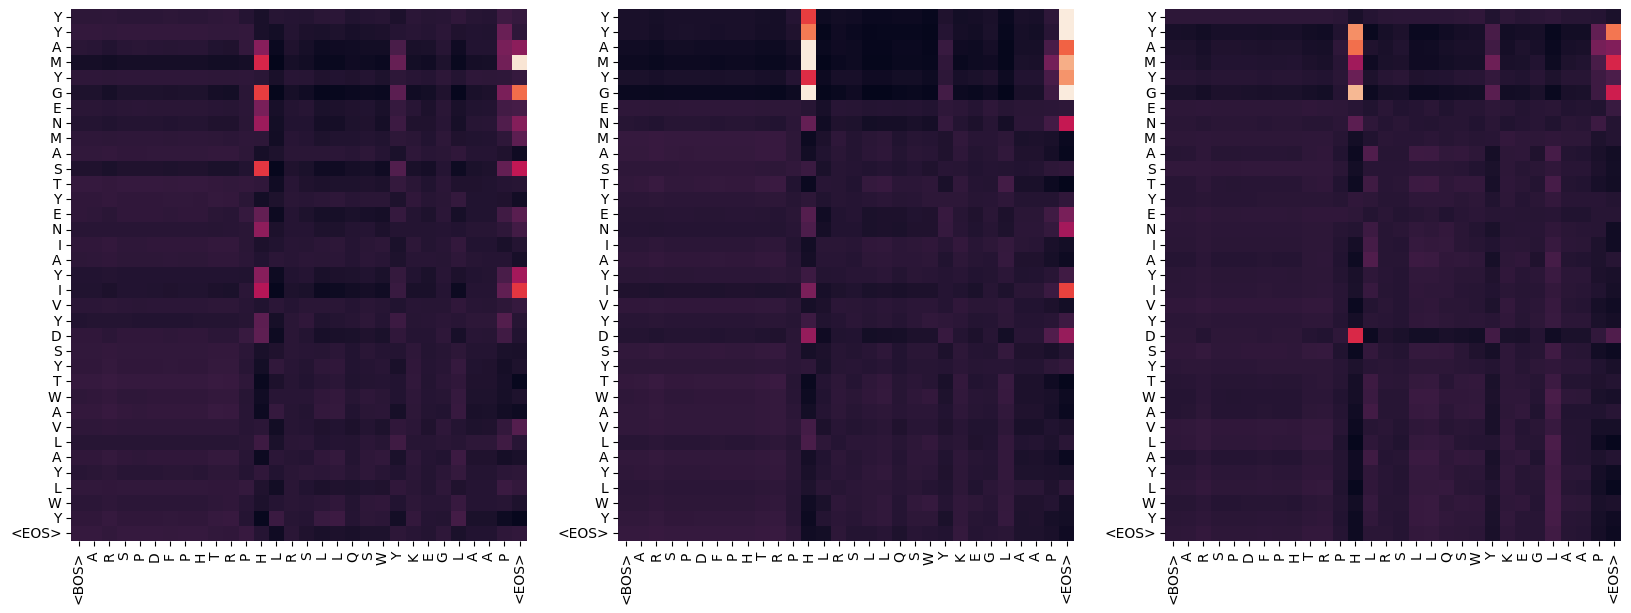

In [11]:
from matplotlib import pyplot as plt
import numpy as np

rows = 1
cols = 3
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
if rows == 1:
    axs = axs[np.newaxis,:]
print(axs)


for i, output in enumerate(captured_outputs):
    output = output.cpu().squeeze(0)
    # print(i)
    draw(output, ['<BOS>']+[x for x in input_sequence] + ['<EOS>'], ([x for x in output_sequence] + ['<EOS>'])[:], ax=axs[i//cols, i%cols])

NameError: name 'attn_matrix' is not defined

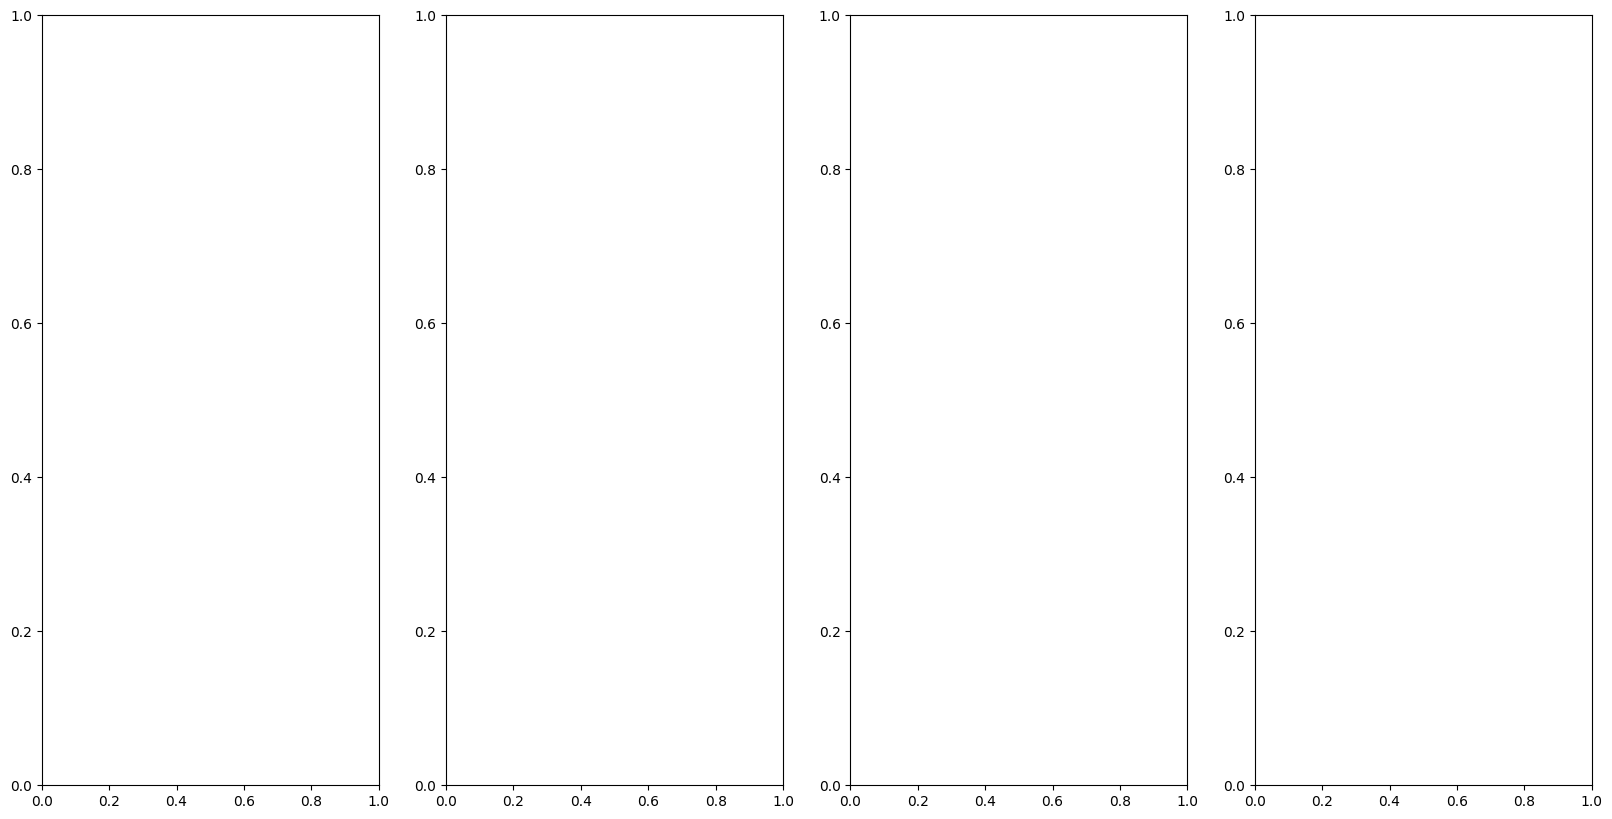

In [12]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,4, figsize=(20, 10))
draw(attn_matrix, ['<BOS>']+[x for x in input_sequence] + ['<EOS>'], [x for x in output_sequence] + ['<EOS>'], ax=axs[0])

In [ ]:
attn_matrix

array([[0.07800207, 0.08235738, 0.0791304 , 0.07796861, 0.07725462,
        0.07873622, 0.07877479, 0.07873113, 0.08095247, 0.07845904,
        0.07592884, 0.05763017, 0.01182073, 0.01417575, 0.01349907,
        0.00589137, 0.03068733],
       [0.0101967 , 0.00950632, 0.00980428, 0.00997536, 0.01044545,
        0.01002026, 0.01001492, 0.01003855, 0.0085303 , 0.00969987,
        0.00966989, 0.01241846, 0.13635808, 0.22494231, 0.0722814 ,
        0.26583946, 0.1802584 ],
       [0.06894936, 0.07205884, 0.07009156, 0.06885941, 0.06809431,
        0.06976791, 0.06961773, 0.06914755, 0.07226378, 0.0701931 ,
        0.07139006, 0.06380502, 0.00859433, 0.02978209, 0.01213242,
        0.02940676, 0.08584577],
       [0.08096255, 0.08579029, 0.08212378, 0.08064237, 0.08001556,
        0.08209688, 0.0812345 , 0.08128063, 0.08589925, 0.08269334,
        0.08393008, 0.07326166, 0.00102062, 0.00264586, 0.00522537,
        0.00437899, 0.00679827],
       [0.08243367, 0.08743656, 0.08372995, 0.082549